In [1]:
import sqlite3
import numpy as np
import pandas as pd
import missingno as msno
from copy import deepcopy
from tqdm.auto import tqdm

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

import plotly.express as px
from plotly.offline import *
init_notebook_mode(connected = True)

/home/rjn/miniconda3/envs/gpu_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Connect to the database 
conn = sqlite3.connect("kijiji_real_estate_gta.db", isolation_level=None,
                       detect_types=sqlite3.PARSE_COLNAMES)

# convert the database into a pandas data frame.
df = pd.read_sql_query("SELECT * FROM properties", conn)


In [3]:
# As database is storing null value as N/A converting N/A to null value, replacing 'N/A' with np.nan
df.replace('N/A', np.nan, inplace=True)

#### Data Scrubbing

Missingness Analysis: 

<Axes: >

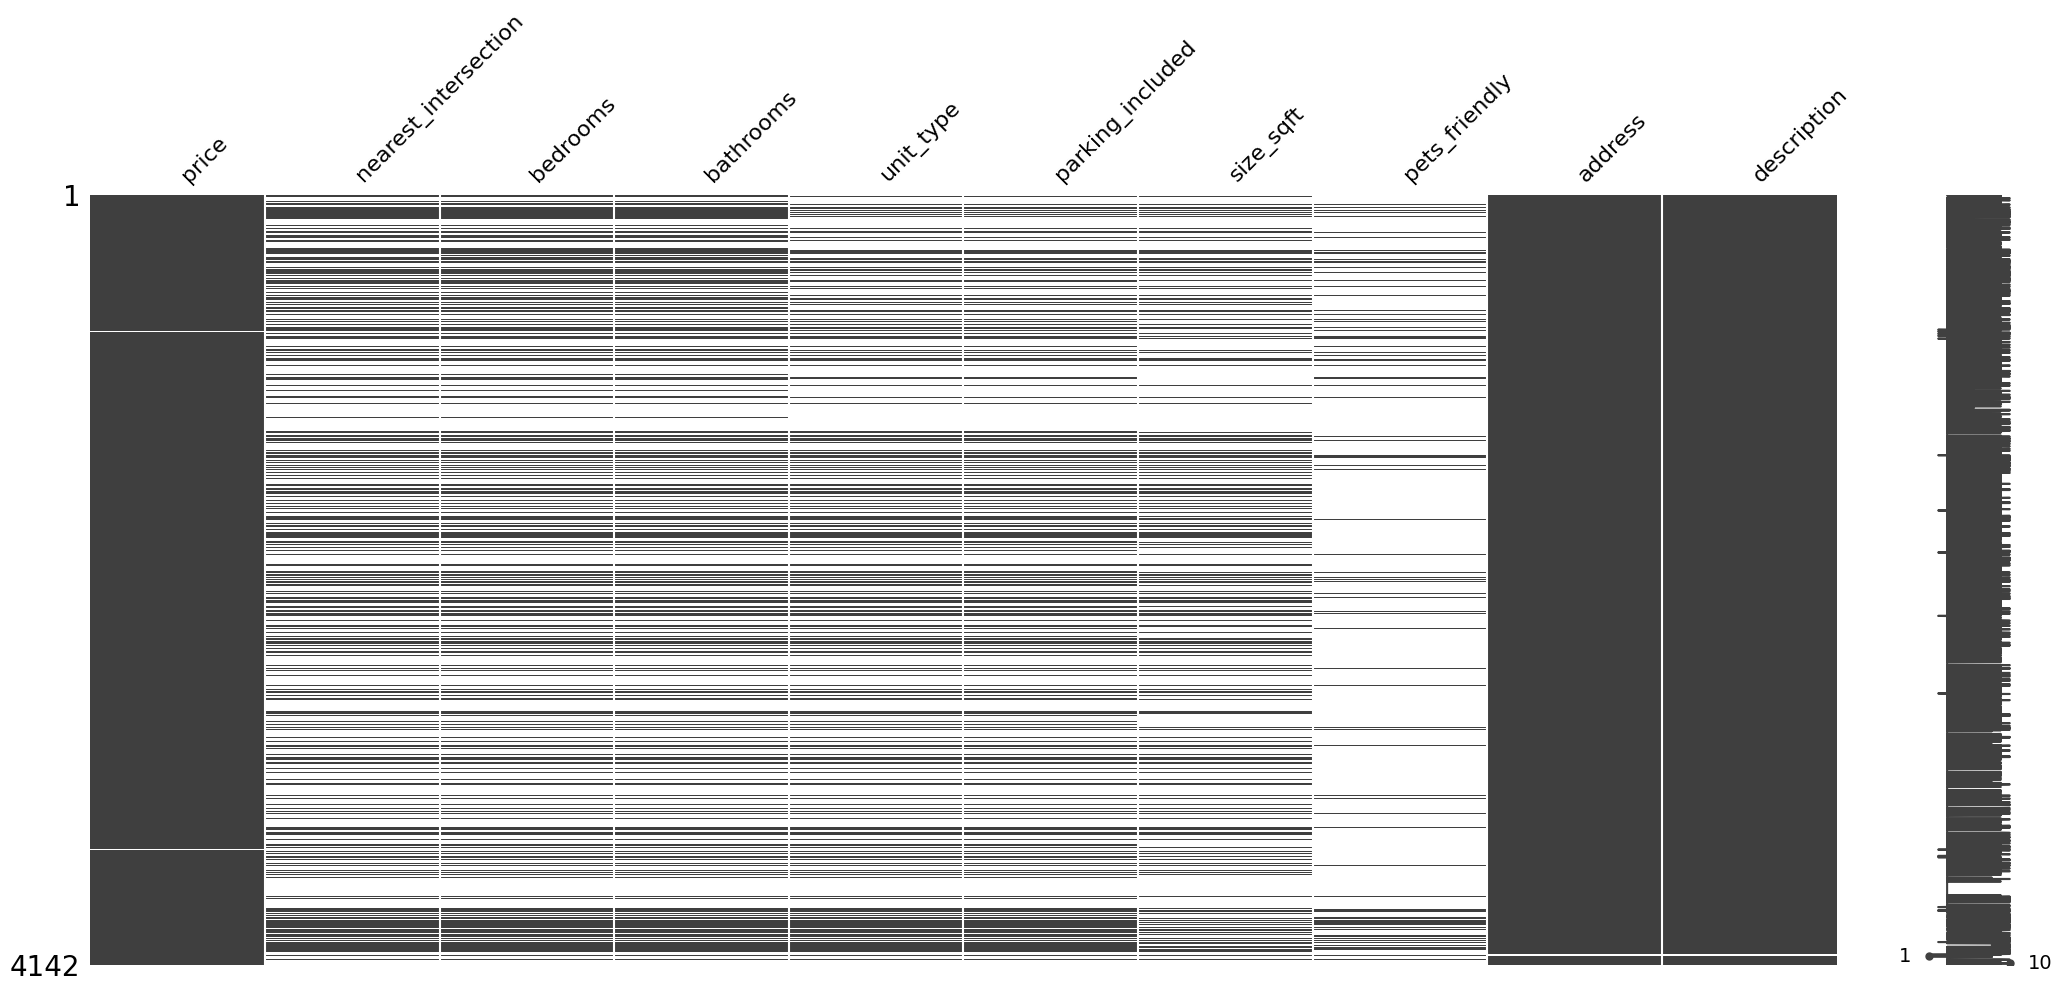

In [4]:
# get all columns with missing values.

col_mis_val = df.columns[df.isnull().sum() > 0]
col_mis_val = col_mis_val.to_list()

# visualize missing values with missingno.

msno.matrix(df[col_mis_val])

Data Completeness per column

<Axes: >

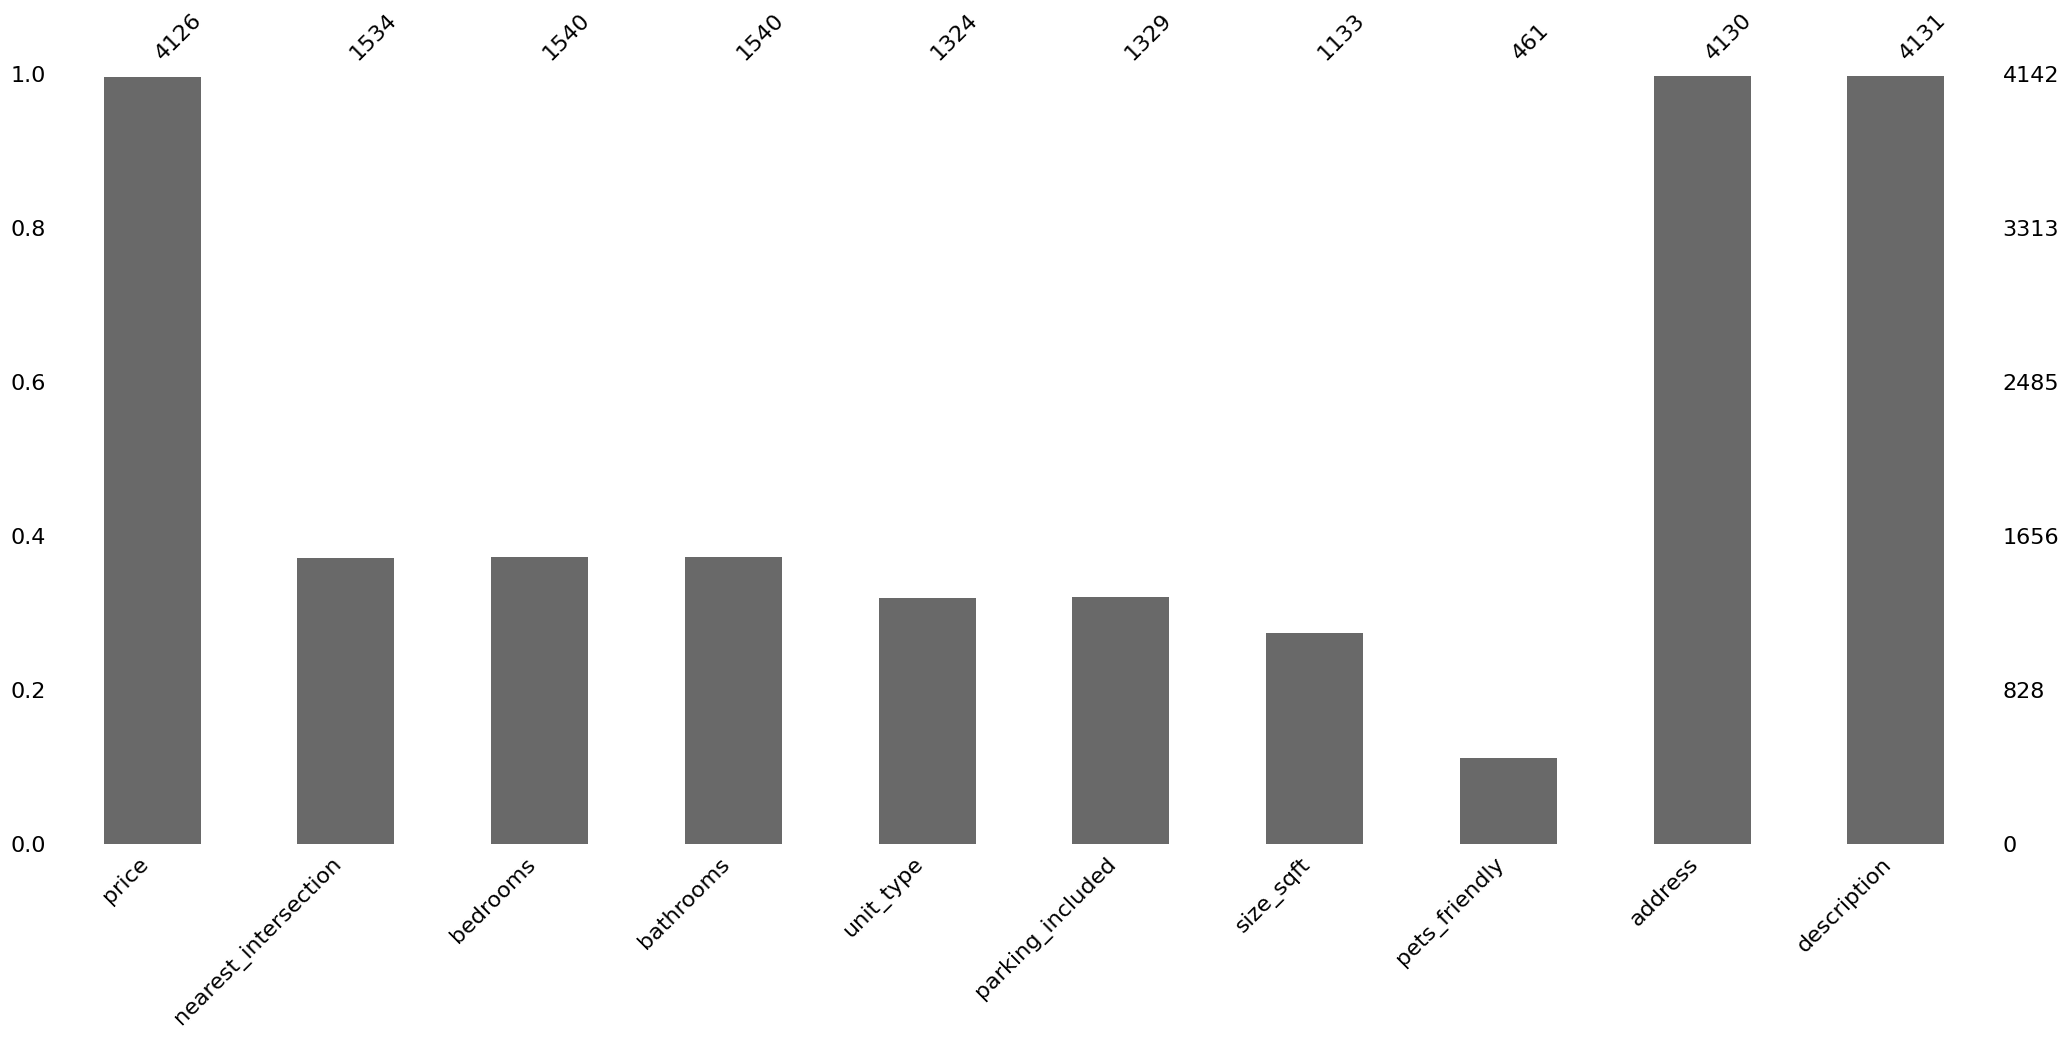

In [5]:
msno.bar(df[col_mis_val])

In [6]:
# Get all columns whose missing values are greater than 50%
to_be_dropeed = df[col_mis_val].columns[df[col_mis_val].isna().mean() * 100 > 50]
print(f"More than 50% missing values:\n{list(to_be_dropeed)}")

More than 50% missing values:
['nearest_intersection', 'bedrooms', 'bathrooms', 'unit_type', 'parking_included', 'size_sqft', 'pets_friendly']


In [7]:
# drop all rows with missing address 
df.dropna(subset=['address'], inplace=True)

print(f"Missing Values in address : {df.address.isnull().sum()}")

Missing Values in address : 0


Missing at Random Check:

In [8]:
# lets check of pets_friendly 
df["pets_friendly"].value_counts()

pets_friendly
Yes    458
Name: count, dtype: int64

Here we can see that data consists of only `Yes` records, so `No` record is intentionally left blank. We can add `No` to all remaining null rows. 

In [9]:
df["pets_friendly"] = df["pets_friendly"].fillna("No")
df["pets_friendly"].value_counts()
# remove if any null values
df.dropna(subset=['pets_friendly'], inplace=True)

#### Feature Engineering

Converting price to proper format.

In [10]:
# Replace 'Please Contact' with np.nan in the price column as some listing contains please contact info. 
df['price'].replace('Please Contact', np.nan, inplace=True)

# Drop rows with NaN in the price column
df.dropna(subset=['price'], inplace=True)

# Remove non-numeric characters from the price and convert to float, trying to remove $
df['price'] = df['price'].str.replace(r'[^0-9.]', '', regex=True).astype(float)

# similar for sqft
df['size_sqft'] = df['size_sqft'].str.replace('sqft', '').astype(float)

/tmp/ipykernel_110449/517652983.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





**Text Cleaner**

In [11]:
from text_cleaner import TextCleaner

# initialize the text cleaner 
txt_cleaner = TextCleaner()

# clean the description
df['description'] = df["description"].apply(txt_cleaner)

# clean the results 
df["title"] = df["title"].apply(txt_cleaner)

Converting address to longitude and latitude. 

In [12]:
import re
import pgeocode
import pandas as pd
from postalcodes_ca import fsa_codes

class PostalCodeProcessor:
    def __init__(self, df, address_column):
        self.df = df
        self.address_column = address_column
        self.nomi = pgeocode.Nominatim('CA')
        self.fsa_codes = fsa_codes

    def extract_postal_codes(self, address):
        pattern = r'\b[A-Z]\d[A-Z][ -]?\d[A-Z]\d\b'
        match = re.search(pattern, address)
        return match.group() if match else None

    def format_canadian_postal_code(self, postal_code):
        pattern = r'^([A-Z]\d[A-Z])?(\s)?(\d[A-Z]\d)$'
        match = re.search(pattern, postal_code.upper())
        if match:
            return f"{match.group(1)} {match.group(3)}" if match.group(2) != '\s' else postal_code.upper()
        return None

    def process_dataframe(self):
        result = []
        for address in self.df[self.address_column]:
            postal_code = self.extract_postal_codes(address)
            if postal_code:
                formatted_postal_code = self.format_canadian_postal_code(postal_code)
                fsa = formatted_postal_code.split()[0]

                try:

                    fsa_result = self.fsa_codes[fsa]
                    city = fsa_result.name.split("(")[0].strip()
                    query = self.nomi.query_postal_code(formatted_postal_code)
                    lat, lon = query["latitude"], query["longitude"]
                    result.append([lat, lon, city])

                except Exception as e:
                    result.append([None, None, None])

            else:
                result.append([None, None, None])
        
        # Add new columns to the dataframe
        self.df['latitude'] = [r[0] for r in result]
        self.df['longitude'] = [r[1] for r in result]
        self.df['city'] = [r[2] for r in result]
        
        return self.df

processor = PostalCodeProcessor(df, "address")

# add longitude, latitude and city in dataframe
df = processor.process_dataframe()

<>:22: SyntaxWarning:

invalid escape sequence '\s'

<>:22: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_110449/430244483.py:22: SyntaxWarning:

invalid escape sequence '\s'



In [13]:
# drop all the rows with either of the missing values.
df.dropna(subset=['latitude', 'longitude', 'city'], inplace=True)


**Handieling Missing Values**

In [14]:
classifier_cols = ['address', 'city', "unit_type"]
bool_cols = ["par"]
regressor_cols = ['price', 'latitude', 'longitude', "size_sqft"]

fe_df = df[classifier_cols+regressor_cols]
fe_df.head()

missing_data_cols = fe_df.isnull().sum()[fe_df.isnull().sum() > 0].index.tolist()

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
import warnings 
warnings.filterwarnings("ignore")



def impute_categorical_missing_data(passed_col):
    
    df_null = fe_df[fe_df[passed_col].isnull()]
    df_not_null = fe_df[fe_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)
        
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):
    
    df_null = fe_df[fe_df[passed_col].isnull()]
    df_not_null = fe_df[fe_df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]
    
    other_missing_cols = [col for col in missing_data_cols if col != passed_col]
    
    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])
    
    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass
                
    if len(df_null) > 0: 
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])
    
    return df_combined[passed_col]



**Now assigning the missing values to the :** 

In [15]:
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((fe_df[col].isnull().sum() / len(fe_df)) * 100, 2))+"%")
    if col in classifier_cols:
        fe_df[col] = impute_categorical_missing_data(col)
    elif col in regressor_cols:
        fe_df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values unit_type : 68.8%
The feature 'unit_type' has been imputed with 72.77 accuracy

Missing Values size_sqft : 74.23%
MAE = 179.74975632911392 



In [21]:
# assign new values to database 
for col in fe_df.columns:
    df[col] = fe_df[col]

In [27]:
# get the final database
df = df[["url","title", "price", "unit_type", "size_sqft", 'address', 'description', 'latitude', 'longitude',
       'city'  ]]


#### EDA

Analyzing the price columns. 

In [28]:
# Create a box plot for the price column
fig = px.box(df, y='price', title='Box Plot of Listing Prices', labels={'price': 'Price'}, template='plotly_dark')

fig.update_layout(
    height=800
)

fig.show()

In [29]:
# Calculate IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.90)
IQR = Q3 - Q1

# Filter out outliers
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]


fig = px.box(df, y='price', title='Box Plot of Listing Prices', labels={'price': 'Price'}, template='plotly_dark')

fig.update_layout(
    height=800
)

fig.show()

Visualization of the listing distribution. 

In [30]:
latitude = df["latitude"].mean()
longitude = df["longitude"].mean()
map = folium.Map(location=[latitude, longitude], zoom_start=11)

marker_cluster = MarkerCluster().add_to(map)

for _, row in df.iterrows():
    folium.Marker(location=[row["latitude"], row["longitude"]], 
                  icon=folium.Icon(color='black',icon_color='#FF0000')).add_to(marker_cluster)

map

**Top 10 city with highest listings.**

In [31]:
# get listings per city
listing_per_city = df.city.value_counts().to_dict()

# convert dict to list
city = list(listing_per_city.keys())[:10]
count = list(listing_per_city.values())[:10]


fig = px.bar(x=city, y=count, text=count, template='plotly_dark')
# fig.update_traces(texttemplate="%{y}", textposition="auto")

fig.update_layout(
    title='Top 10 cities with property listing.',
    xaxis_title='city',
    yaxis_title='Number of listings.',
    xaxis={'categoryorder':'total descending'},
    height=800
)

fig.show()

**Top 10 Average price per city**

In [32]:
avg_price_per_city = df.groupby('city')['price'].mean().reset_index()

avg_price_per_city = avg_price_per_city.sort_values(by='price', ascending=False)[:10]

fig = px.bar(avg_price_per_city, x='city', y='price', title='Average Listing Price per City', labels={'price': 'Average Price', 'city': 'City'},text=avg_price_per_city["price"], template='plotly_dark')

fig.update_layout(
    title='Average price in top 10 cities.',
    xaxis_title='City',
    yaxis_title='Average Listing price.',
    xaxis={'categoryorder':'total descending'},
    height=800
)

fig.show()


**Heatmap of price distribution:**

In [33]:
lats_longs_weight = [[x[-1]["latitude"],x[-1]["longitude"],x[-1]["price"]] for x in df.iterrows()]

In [34]:
map_obj = folium.Map(location=[latitude, longitude] , zoom_start = 9)

HeatMap(lats_longs_weight).add_to(map_obj)

map_obj

**Text description analysis:**